In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('pima-indians-diabetes.csv')

In [3]:
df.shape

(768, 9)

In [4]:
df.head()

,Pregnancies,PlasmaGlucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   PlasmaGlucose             768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.isna().sum()

Pregnancies                 0
PlasmaGlucose               0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

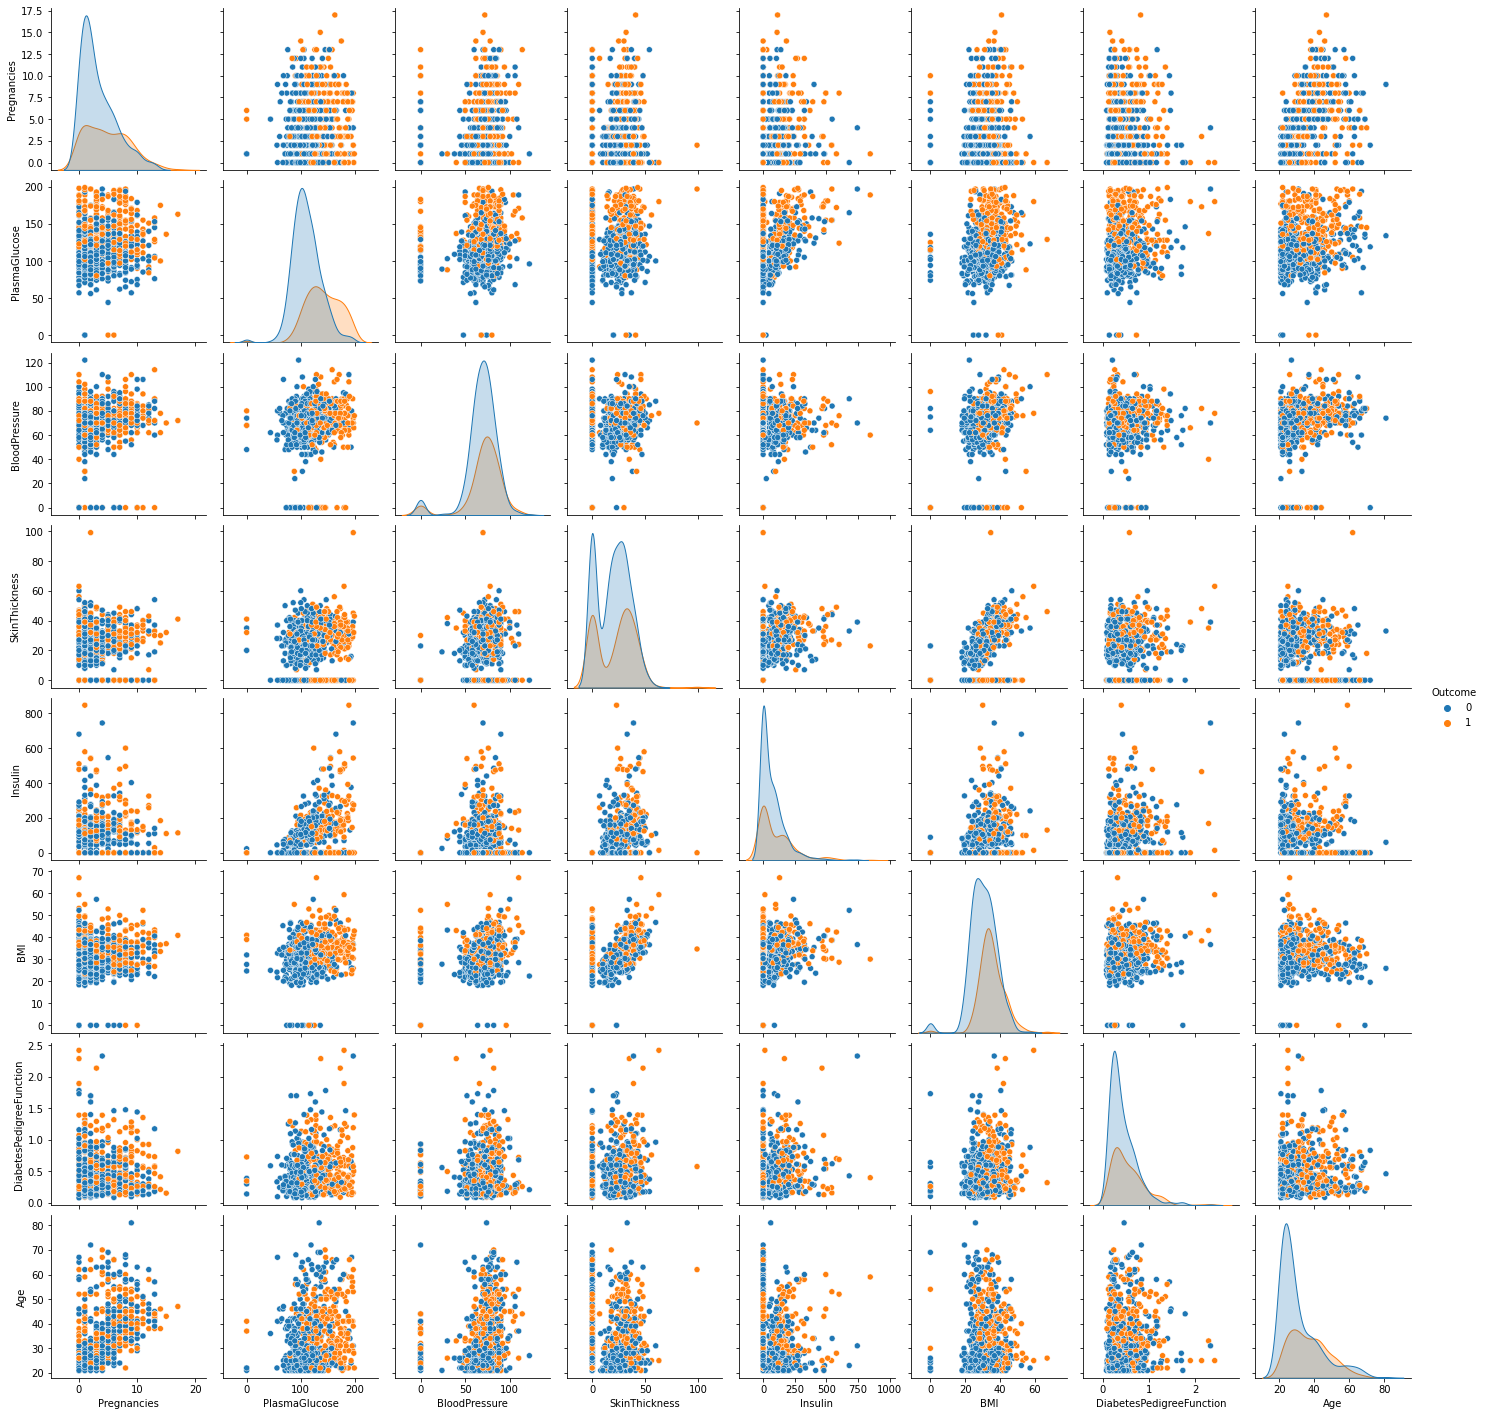

In [7]:
sns.pairplot(df,hue='Outcome')

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop('Outcome',axis=1).values
y = df['Outcome'].values
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [9]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [10]:
class ANN(nn.Module):
    def __init__(self,input_features=8,hidden1=20,hidden2=20,out_features=2):
        super().__init__()
        self.layer1 = nn.Linear(input_features,hidden1)
        self.layer2 = nn.Linear(hidden1,hidden2)
        self.predictions = nn.Linear(hidden2,out_features)

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.predictions(x)
        return x

In [11]:
torch.manual_seed(20)

model = ANN()

In [12]:
model.parameters

<bound method Module.parameters of ANN(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (predictions): Linear(in_features=20, out_features=2, bias=True)
)>

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [14]:
epochs = 200
final_losses = []
for i in range(epochs):
    i=i+1
    y_pred = model.forward(X_train)
    loss = loss_function(y_pred,y_train)
    
    final_losses.append(loss.item())
    if i%10==1:
        print(f'Epoch: {i} Loss : {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1 Loss : 3.4572105407714844
Epoch: 11 Loss : 0.8019207715988159
Epoch: 21 Loss : 0.6090320944786072
Epoch: 31 Loss : 0.5917771458625793
Epoch: 41 Loss : 0.5679708123207092
Epoch: 51 Loss : 0.5529041886329651
Epoch: 61 Loss : 0.5410094857215881
Epoch: 71 Loss : 0.5310389995574951
Epoch: 81 Loss : 0.5220361351966858
Epoch: 91 Loss : 0.5135972499847412
Epoch: 101 Loss : 0.5061254501342773
Epoch: 111 Loss : 0.4983409643173218
Epoch: 121 Loss : 0.49605512619018555
Epoch: 131 Loss : 0.4828636944293976
Epoch: 141 Loss : 0.47558996081352234
Epoch: 151 Loss : 0.48198652267456055
Epoch: 161 Loss : 0.48064684867858887
Epoch: 171 Loss : 0.47069016098976135
Epoch: 181 Loss : 0.4590848684310913
Epoch: 191 Loss : 0.45079556107521057


Text(0.5, 0, 'Epoch')

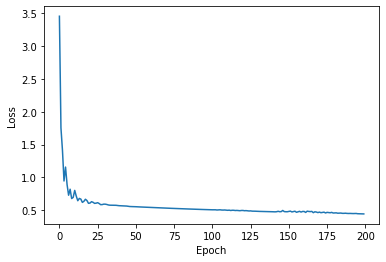

In [15]:
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [16]:
predictions = []
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions)
cm

array([[86, 21],
       [17, 30]], dtype=int64)

Text(69.0, 0.5, 'Predicted Values')

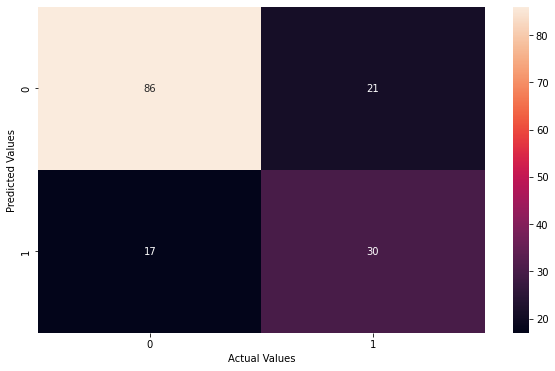

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [19]:
#Classification Report scores
from sklearn.metrics import classification_report,RocCurveDisplay
cr = classification_report(y_test,predictions)
print(cr)


              precision    recall  f1-score   support

           0       0.83      0.80      0.82       107
           1       0.59      0.64      0.61        47

    accuracy                           0.75       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.76      0.75      0.76       154



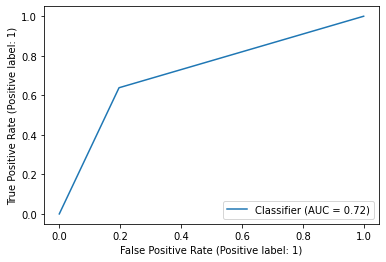

In [20]:
#Displaying an ROC Curve
roc_disp = RocCurveDisplay.from_predictions(y_test, predictions)
roc_disp

In [21]:
#Saving Model
torch.save(model,'Diabetes.pt')

In [22]:
#Loading Model
model = torch.load('Diabetes.pt')

In [23]:
model.eval()

ANN(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (predictions): Linear(in_features=20, out_features=2, bias=True)
)

In [25]:
#New Prediction
new_pred = torch.tensor([ 5.0,140,60,44,0.0,28.6,0.555,41.0])
with torch.no_grad():
        print(model(new_pred).argmax().item())
#Have Diabetes

1
